In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sqlite3
from scipy.stats import poisson

In [120]:
# Get the current working directory
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "databases")

print(new_directory)

# Create a new SQLite database (or connect to an existing one)
db_name_1 = os.path.join(new_directory, 'fbref_data_team_individual.db')

conn = sqlite3.connect(db_name_1)
df_individual = pd.read_sql_query('SELECT * FROM team_individual_tbl', conn)
conn.close()

df_current = df_individual[df_individual['year'] == '2023-2024']

df_current.tail(5)

/Users/richard/Desktop/Projects/football-streamlit-app/football-streamlit-app/data/databases


,index,date,round,venue,result,gf,ga,opponent,xg,xga,possession,xg_roll,xga_roll,team,year
2626,11,2023-11-12 00:00:00,Matchweek 12,Away,D,4.0,4.0,Chelsea,2.9,2.9,55,2.16,1.03,Manchester City,2023-2024
2627,11,2023-11-12 00:00:00,Matchweek 12,Home,W,3.0,2.0,Nott'ham Forest,1.8,1.7,54,1.47,1.85,West Ham,2023-2024
2628,11,2023-11-12 00:00:00,Matchweek 12,Home,W,3.0,1.0,Fulham,3.0,0.9,51,1.88,1.2,Aston Villa,2023-2024
2629,11,2023-11-12 00:00:00,Matchweek 12,Away,L,2.0,3.0,West Ham,1.7,1.8,46,1.06,1.72,Nott'ham Forest,2023-2024
2630,11,2023-11-12 00:00:00,Matchweek 12,Away,D,1.0,1.0,Brighton,1.1,1.5,39,0.87,2.29,Sheffield Utd,2023-2024


In [121]:
# Load the data
# data = pd.read_csv('/mnt/data/current_data.csv')
data = df_current

# Calculate the league average xGA
average_xga_correct = data['xga'].mean()

# Define a minimum xGA value to prevent division by zero
min_xga_value = 0.1

# Define a maximum scaling factor to prevent extreme values
max_scaling_factor = 1.2  # This means we will not adjust any team's xG by more than 50%

# Function to adjust xG with a cap on the scaling factor
def adjust_xg_with_cap(team_xg, opponent_xga, league_avg_xga, max_scaling):
    scaling_factor = league_avg_xga / opponent_xga
    # Cap the scaling factor at the maximum value
    scaling_factor = min(scaling_factor, max_scaling)
    scaling_factor = max(scaling_factor, 1/max_scaling)  # Also ensure we have a lower bound
    return team_xg * scaling_factor

# Recalculate the adjusted xG for each team using the capped adjustment
team_adjusted_xg_capped = {}

for index, row in data.iterrows():
    team = row['team']
    opponent_xga = max(row['xga'], min_xga_value)  # Avoid division by zero
    
    # Adjust the team's xG using the capped scaling method
    adjusted_xg = adjust_xg_with_cap(row['xg'], opponent_xga, average_xga_correct, max_scaling_factor)
    
    # Add the adjusted xG to the team's total and increment the number of games
    if team not in team_adjusted_xg_capped:
        team_adjusted_xg_capped[team] = {'total_adjusted_xg': 0, 'games_played': 0}
    
    team_adjusted_xg_capped[team]['total_adjusted_xg'] += adjusted_xg
    team_adjusted_xg_capped[team]['games_played'] += 1

# Calculate the attacking strength for each team by averaging the adjusted xG over the number of games played
for team in team_adjusted_xg_capped:
    team_adjusted_xg_capped[team]['attacking_strength'] = team_adjusted_xg_capped[team]['total_adjusted_xg'] / team_adjusted_xg_capped[team]['games_played']

# Convert the adjusted attacking strengths into a DataFrame for better visualization
attacking_strength_df_capped = pd.DataFrame.from_dict(team_adjusted_xg_capped, orient='index').reset_index()
attacking_strength_df_capped.rename(columns={'index': 'Team', 'attacking_strength': 'Attacking Strength'}, inplace=True)

# Sort by attacking strength and reset index for the final DataFrame
attacking_strength_df_capped = attacking_strength_df_capped.sort_values(by='Attacking Strength', ascending=False).reset_index(drop=True)

# Display the final DataFrame
attacking_strength_df_capped.head(5)


,Team,total_adjusted_xg,games_played,Attacking Strength
0,Liverpool,29.428595,12,2.452383
1,Manchester City,28.064940,12,2.338745
2,Chelsea,27.516184,12,2.293015
3,Newcastle Utd,26.650807,12,2.220901
4,Aston Villa,26.239491,12,2.186624


In [122]:
# Load the data
# data = pd.read_csv('/mnt/data/current_data.csv')
data = df_current

# Calculate the league average xG
average_xg = data['xg'].mean()

# Define a minimum xGA value to prevent division by zero
min_xga_value = 0.1

# Define a maximum scaling factor to prevent extreme values
max_scaling_factor = 1.2  # This means we will not adjust any team's xGA by more than 50%

# Function to adjust xGA with a cap on the scaling factor
def adjust_xga_with_cap(team_xga, opponent_xg, league_avg_xg, max_scaling):
    scaling_factor = league_avg_xg / opponent_xg
    # Cap the scaling factor at the maximum value
    scaling_factor = min(scaling_factor, max_scaling)
    scaling_factor = max(scaling_factor, 1/max_scaling)  # Also ensure we have a lower bound
    return team_xga * scaling_factor

# Recalculate the adjusted xGA for each team using the capped adjustment
team_adjusted_xga_capped = {}

for index, row in data.iterrows():
    team = row['team']
    opponent_xg = max(row['xg'], min_xga_value)  # Avoid division by zero (using min_xga_value for convenience)
    
    # Adjust the team's xGA using the capped scaling method
    adjusted_xga = adjust_xga_with_cap(row['xga'], opponent_xg, average_xg, max_scaling_factor)
    
    # Add the adjusted xGA to the team's total and increment the number of games
    if team not in team_adjusted_xga_capped:
        team_adjusted_xga_capped[team] = {'total_adjusted_xga': 0, 'games_played': 0}
    
    team_adjusted_xga_capped[team]['total_adjusted_xga'] += adjusted_xga
    team_adjusted_xga_capped[team]['games_played'] += 1

# Calculate the defensive strength for each team by averaging the adjusted xGA over the number of games played
for team in team_adjusted_xga_capped:
    team_adjusted_xga_capped[team]['defensive_strength'] = team_adjusted_xga_capped[team]['total_adjusted_xga'] / team_adjusted_xga_capped[team]['games_played']

# Convert the adjusted defensive strengths into a DataFrame for better visualization
defensive_strength_df_capped = pd.DataFrame.from_dict(team_adjusted_xga_capped, orient='index').reset_index()
defensive_strength_df_capped.rename(columns={'index': 'Team', 'defensive_strength': 'Defensive Strength'}, inplace=True)

# Sort by defensive strength (lower is better) and reset index for the final DataFrame
defensive_strength_df_capped = defensive_strength_df_capped.sort_values(by='Defensive Strength', ascending=True).reset_index(drop=True)

# Display the final DataFrame
defensive_strength_df_capped.head(5)


,Team,total_adjusted_xga,games_played,Defensive Strength
0,Arsenal,9.166690,12,0.763891
1,Manchester City,10.105962,12,0.842163
2,Newcastle Utd,13.148244,12,1.095687
3,Chelsea,13.613798,12,1.134483
4,Liverpool,14.075226,12,1.172936


In [123]:
overall_strength = attacking_strength_df_capped.merge(defensive_strength_df_capped, how='left', on='Team')
overall_strength['Overall Strength'] = overall_strength['Attacking Strength'] - overall_strength['Defensive Strength']
overall_strength = overall_strength.sort_values(by='Overall Strength', ascending=False).reset_index(drop=True)
overall_strength.head(5)

,Team,total_adjusted_xg,games_played_x,Attacking Strength,total_adjusted_xga,games_played_y,Defensive Strength,Overall Strength
0,Manchester City,28.064940,12,2.338745,10.105962,12,0.842163,1.496582
1,Arsenal,25.056973,12,2.088081,9.166690,12,0.763891,1.324190
2,Liverpool,29.428595,12,2.452383,14.075226,12,1.172936,1.279447
3,Chelsea,27.516184,12,2.293015,13.613798,12,1.134483,1.158532
4,Newcastle Utd,26.650807,12,2.220901,13.148244,12,1.095687,1.125214


In [124]:
# Creating a DataFrame for the upcoming fixtures
# Get the current working directory
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")

upcoming_fixtures = pd.read_csv(new_directory + '/fixtures_overall.csv')

df_upcoming_fixtures = upcoming_fixtures
df_overall_strength = overall_strength

df_upcoming_fixtures = df_upcoming_fixtures.dropna(subset=['Home', 'Away'])

# Use the same method to predict the goals for each game in the upcoming fixtures
predicted_goals_all_fixtures = []

# Adjusting for home advantage
home_advantage_factor = 1.1
away_advantage_factor = 0.9

average_xga_league = df_overall_strength['total_adjusted_xga'].sum() / df_overall_strength['games_played_y'].sum()

print(average_xga_league)

for index, row in df_upcoming_fixtures.iterrows():
    home_team = row['Home']
    away_team = row['Away']
    week = row['Wk']

    # print(home_team, away_team, week)
    
    # Get the attacking strength of the home team and the defensive strength of the away team
    home_team_att_strength = df_overall_strength[df_overall_strength['Team'] == home_team]['Attacking Strength'].values[0]
    away_team_def_strength = df_overall_strength[df_overall_strength['Team'] == away_team]['Defensive Strength'].values[0]
    
    # Calculate the predicted goals using the formula
    predicted_goals_for_home_team = home_team_att_strength * home_advantage_factor * (away_team_def_strength / average_xga_league)
    
    # Get the attacking strength of the away team and the defensive strength of the home team
    away_team_att_strength = df_overall_strength[df_overall_strength['Team'] == away_team]['Attacking Strength'].values[0]
    home_team_def_strength = df_overall_strength[df_overall_strength['Team'] == home_team]['Defensive Strength'].values[0]
    
    # Calculate the predicted goals using the formula
    predicted_goals_for_away_team = away_team_att_strength * away_advantage_factor * (home_team_def_strength / average_xga_league)
    
    # Store the predictions in the list
    predicted_goals_all_fixtures.append({
        "Week": week,
        "Home": home_team,
        "Away": away_team,
        "Predicted Goals (Home)": predicted_goals_for_home_team,
        "Predicted Goals (Away)": predicted_goals_for_away_team
    })

# Convert the predictions list to a DataFrame
df_predicted_goals_all_fixtures = pd.DataFrame(predicted_goals_all_fixtures)
df_predicted_goals_all_fixtures['goal_diff'] = abs(df_predicted_goals_all_fixtures['Predicted Goals (Home)'] - df_predicted_goals_all_fixtures['Predicted Goals (Away)'])
df_predicted_goals_all_fixtures['Predicted Goals (Home)'] = df_predicted_goals_all_fixtures['Predicted Goals (Home)'].round(2)
df_predicted_goals_all_fixtures['Predicted Goals (Away)'] = df_predicted_goals_all_fixtures['Predicted Goals (Away)'].round(2)
df_predicted_goals_all_fixtures['goal_diff'] = df_predicted_goals_all_fixtures['goal_diff'].round(2)
df_predicted_goals_all_fixtures.head(5)  # Displaying only the fixtures we created for brevity


1.61112995373363


,Week,Home,Away,Predicted Goals (Home),Predicted Goals (Away),goal_diff
0,1.0,Burnley,Manchester City,0.46,2.86,2.40
1,1.0,Arsenal,Nott'ham Forest,2.49,0.47,2.02
2,1.0,Everton,Fulham,2.41,0.81,1.59
3,1.0,Sheffield Utd,Crystal Palace,0.83,1.88,1.05
4,1.0,Brighton,Luton Town,2.81,0.81,2.00


In [125]:
# Assuming df_fixture_predictions is your existing DataFrame with the predicted goals
# Add two new columns for clean sheet probabilities for home and away teams

def calculate_clean_sheet_probability(xG_against):
    return poisson.pmf(0, xG_against)

df_predicted_goals_all_fixtures['Home Clean Sheet %'] = df_predicted_goals_all_fixtures['Predicted Goals (Away)'].apply(calculate_clean_sheet_probability).round(2) * 100
df_predicted_goals_all_fixtures['Away Clean Sheet %'] = df_predicted_goals_all_fixtures['Predicted Goals (Home)'].apply(calculate_clean_sheet_probability).round(2) * 100

df_predicted_goals_all_fixtures.tail(5)

,Week,Home,Away,Predicted Goals (Home),Predicted Goals (Away),goal_diff,Home Clean Sheet %,Away Clean Sheet %
375,38.0,Brentford,Newcastle Utd,1.44,1.68,0.24,19.0,24.0
376,38.0,Chelsea,Bournemouth,3.60,0.70,2.90,50.0,3.0
377,38.0,Crystal Palace,Aston Villa,1.11,1.92,0.80,15.0,33.0
378,38.0,Liverpool,Wolves,2.89,0.90,1.98,41.0,6.0
379,38.0,Burnley,Nott'ham Forest,0.95,1.35,0.40,26.0,39.0


In [126]:
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")

df_predicted_goals_all_fixtures.to_csv(new_directory + '/predicted_data.csv', index=False)

In [100]:
# Parameters for selection
team = 'Tottenham'
start_week = 12
end_week = start_week + 7  # This includes the starting week and the next 7 weeks

current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")

df_predicted_goals_all_fixtures = pd.read_csv(new_directory + '/predicted_data.csv')

# Select rows where 'Tottenham' is either in 'Home' or 'Away', and the 'Week' is within the specified range
df_selected = df_predicted_goals_all_fixtures[
    ((df_predicted_goals_all_fixtures['Home'] == team) | (df_predicted_goals_all_fixtures['Away'] == team)) &
    (df_predicted_goals_all_fixtures['Week'].between(start_week, end_week))
]

df_selected

,Unnamed: 0,Week,Home,Away,Predicted Goals (Home),Predicted Goals (Away),goal_diff,Home Clean Sheet %,Away Clean Sheet %
110,110,12.0,Wolves,Tottenham,1.33,1.86,0.52,16.0,26.0
125,125,13.0,Tottenham,Aston Villa,1.62,1.76,0.14,17.0,20.0
131,131,14.0,Manchester City,Tottenham,2.44,0.71,1.73,49.0,9.0
143,143,15.0,Tottenham,West Ham,2.52,1.21,1.31,30.0,8.0
156,156,16.0,Tottenham,Newcastle Utd,1.16,2.04,0.88,13.0,31.0
165,165,17.0,Nott'ham Forest,Tottenham,1.12,1.79,0.66,17.0,33.0
175,175,18.0,Tottenham,Everton,1.63,1.45,0.18,23.0,20.0
182,182,19.0,Brighton,Tottenham,1.88,1.39,0.49,25.0,15.0


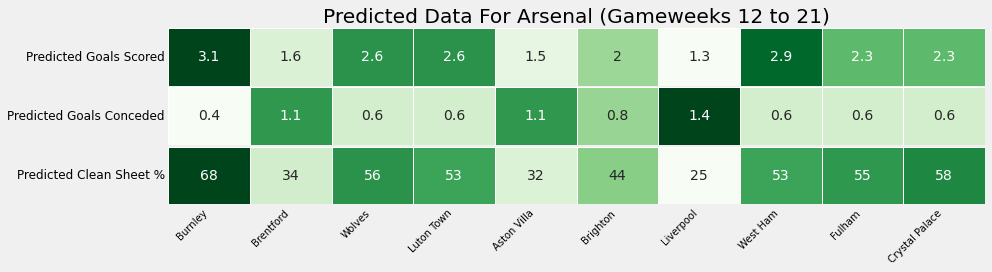

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
team = 'Arsenal'
start_week = 12
end_week = start_week + 9

# Bring in the predicted data
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")
df_predicted_goals_all_fixtures = pd.read_csv(new_directory + '/predicted_data.csv')

# Select rows for the team selected within the gameweek range
df_selected = df_predicted_goals_all_fixtures[
    ((df_predicted_goals_all_fixtures['Home'] == team) | (df_predicted_goals_all_fixtures['Away'] == team)) &
    (df_predicted_goals_all_fixtures['Week'].between(start_week, end_week))]

# Get teams home and away data
df_selected_home = df_selected[df_selected['Home'] == team].set_index('Week')
df_selected_away = df_selected[df_selected['Away'] == team].set_index('Week')

df_selected_home['Predicted Goals (Home)'] = df_selected_home['Predicted Goals (Home)'].round(1)
df_selected_home['Predicted Goals (Away)'] = df_selected_home['Predicted Goals (Away)'].round(1)
df_selected_away['Predicted Goals (Home)'] = df_selected_away['Predicted Goals (Home)'].round(1)
df_selected_away['Predicted Goals (Away)'] = df_selected_away['Predicted Goals (Away)'].round(1)

# Set up predicted goals scored for each game week
predicted_goals_scored = []
opponents_list = []
for week in range(start_week, end_week + 1):
    if week in df_selected_home.index:
        predicted_goals_scored.append(df_selected_home.loc[week, 'Predicted Goals (Home)'])
        opponents_list.append(df_selected_home.loc[week, 'Away'])
    elif week in df_selected_away.index:
        predicted_goals_scored.append(df_selected_away.loc[week, 'Predicted Goals (Away)'])
        opponents_list.append(df_selected_away.loc[week, 'Home'])
    else:
        predicted_goals_scored.append(None)
        opponents_list.append("No Match")

# Set up predicted goals conceded for each game week
predicted_goals_conceded = []
opponents_list = [] 
for week in range(start_week, end_week + 1):
    if week in df_selected_home.index:
        predicted_goals_conceded.append(df_selected_home.loc[week, 'Predicted Goals (Away)'])
        opponents_list.append(df_selected_home.loc[week, 'Away'])
    elif week in df_selected_away.index:
        predicted_goals_conceded.append(df_selected_away.loc[week, 'Predicted Goals (Home)'])
        opponents_list.append(df_selected_away.loc[week, 'Home'])
    else:
        predicted_goals_conceded.append(None)
        opponents_list.append("No Match")

# Set up clean sheet percentages for each game week
clean_sheet_pct = []
opponents_list = []
for week in range(start_week, end_week + 1):
    if week in df_selected_home.index:
        clean_sheet_pct.append(df_selected_home.loc[week, 'Home Clean Sheet %'])
        opponents_list.append(df_selected_home.loc[week, 'Away'])
    elif week in df_selected_away.index:
        clean_sheet_pct.append(df_selected_away.loc[week, 'Away Clean Sheet %'])
        opponents_list.append(df_selected_away.loc[week, 'Home'])
    else:
        clean_sheet_pct.append(None)
        opponents_list.append("No Match")

# Create dataframes for each of the rows needed
df_goals_scored = pd.DataFrame(predicted_goals_scored, index=opponents_list, columns=['Predicted Goals Scored']).transpose()
df_goals_conceded = pd.DataFrame(predicted_goals_conceded, index=opponents_list, columns=['Predicted Goals Conceded']).transpose()
df_cleansheets_pct = pd.DataFrame(clean_sheet_pct, index=opponents_list, columns=['Predicted Clean Sheet %']).transpose()

# Plot the heatmap
plt.figure(figsize=(14, 4)) 

# 1st plot
plt.subplot(3, 1, 1)
sns.heatmap(df_goals_scored, annot=True, cmap="Greens", cbar=False, linewidths=.5)
plt.xticks([]) 
plt.yticks(rotation=0, fontsize=12)
plt.title(f'Predicted Data For {team} (Gameweeks {start_week} to {end_week})')

# 2nd plot
plt.subplot(3, 1, 2) 
sns.heatmap(df_goals_conceded, annot=True, cmap="Greens", cbar=False, linewidths=.5)
plt.xticks([]) 
plt.yticks(rotation=0, fontsize=12)

# 3rd plot
plt.subplot(3, 1, 3)
sns.heatmap(df_cleansheets_pct, annot=True, cmap="Greens", cbar=False, linewidths=.5)
plt.xticks(ticks=np.arange(0.5, len(opponents_list)), labels=opponents_list, rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout(h_pad=0.1)  
plt.show()

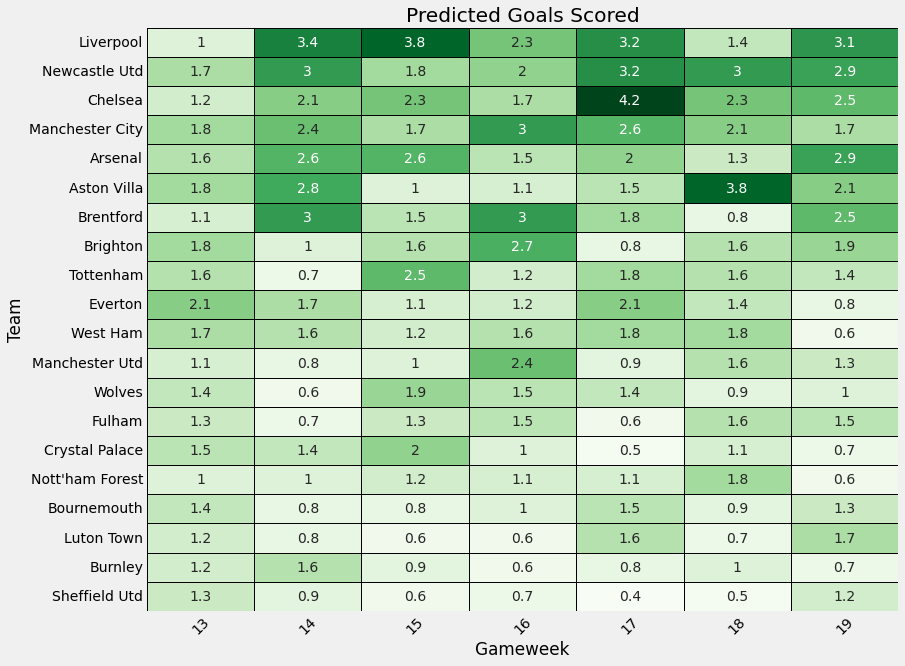

In [118]:
# Bring in the predicted data
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")
df_predicted_goals_all_fixtures = pd.read_csv(new_directory + '/predicted_data.csv')

df = df_predicted_goals_all_fixtures

start_week = 13
end_week = start_week + 7

# Filter for the weeks wanted
df = df[df['Week'].between(start_week, end_week)]
df = df.round(1)
teams = np.unique(df[['Home', 'Away']].values) 
goals_scored_pivot = pd.DataFrame(index=teams)

# Predicted goals for each team
for week in range(start_week, end_week):
    goals_scored_pivot[week] = 0  # Initialise
    week_games = df[df['Week'] == week]
    for _, row in week_games.iterrows():
        goals_scored_pivot.at[row['Home'], week] += row['Predicted Goals (Home)']
        goals_scored_pivot.at[row['Away'], week] += row['Predicted Goals (Away)']

# Calculate the total predicted goals for each team
goals_scored_pivot['Total'] = goals_scored_pivot.sum(axis=1)

# Sort by the total (and remove)
goals_scored_pivot_sorted = goals_scored_pivot.sort_values('Total', ascending=False)
goals_scored_pivot_sorted = goals_scored_pivot_sorted.drop(columns='Total')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(goals_scored_pivot_sorted, annot=True, cmap="Greens", cbar=False, linewidths=1, linecolor='black')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Gameweek')
plt.ylabel('Team')
plt.title('Predicted Goals Scored')
plt.show()


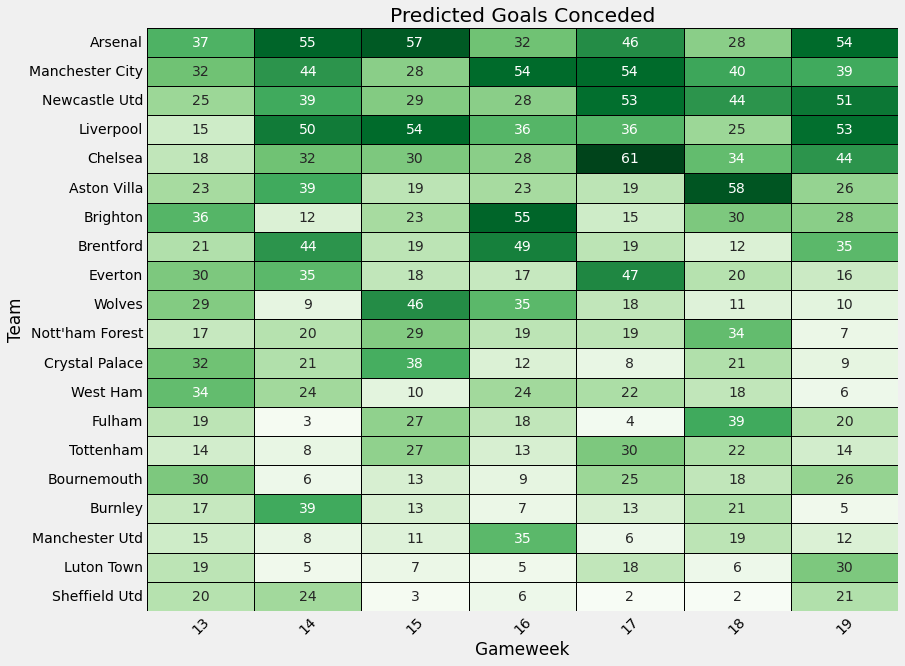

In [130]:
# Bring in the predicted data
current_dir = os.getcwd()
new_directory = os.path.join(current_dir,"data", "raw_files")
df_predicted_goals_all_fixtures = pd.read_csv(new_directory + '/predicted_data.csv')

df = df_predicted_goals_all_fixtures

start_week = 13
end_week = start_week + 7

# Filter for the weeks wanted
df = df[df['Week'].between(start_week, end_week)]
df = df.round(1)
teams = np.unique(df[['Home', 'Away']].values) 
goals_scored_pivot = pd.DataFrame(index=teams)

# Predicted goals for each team
for week in range(start_week, end_week):
    goals_scored_pivot[week] = 0  # Initialise
    week_games = df[df['Week'] == week]
    for _, row in week_games.iterrows():
        goals_scored_pivot.at[row['Home'], week] += row['Home Clean Sheet %']
        goals_scored_pivot.at[row['Away'], week] += row['Away Clean Sheet %']

# Calculate the total predicted goals for each team
goals_scored_pivot['Total'] = goals_scored_pivot.sum(axis=1)

# Sort by the total (and remove)
goals_scored_pivot_sorted = goals_scored_pivot.sort_values('Total', ascending=False)
goals_scored_pivot_sorted = goals_scored_pivot_sorted.drop(columns='Total')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(goals_scored_pivot_sorted, annot=True, cmap="Greens", cbar=False, linewidths=1, linecolor='black')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Gameweek')
plt.ylabel('Team')
plt.title('Predicted Clean Sheet %')
plt.show()


/var/folders/vd/ly4k__lj017dwcj6ngy4n4c00000gn/T/ipykernel_58110/2520294738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Max Clean Sheet Probability'] = data[['Home Clean Sheet %', 'Away Clean Sheet %']].max(axis=1)


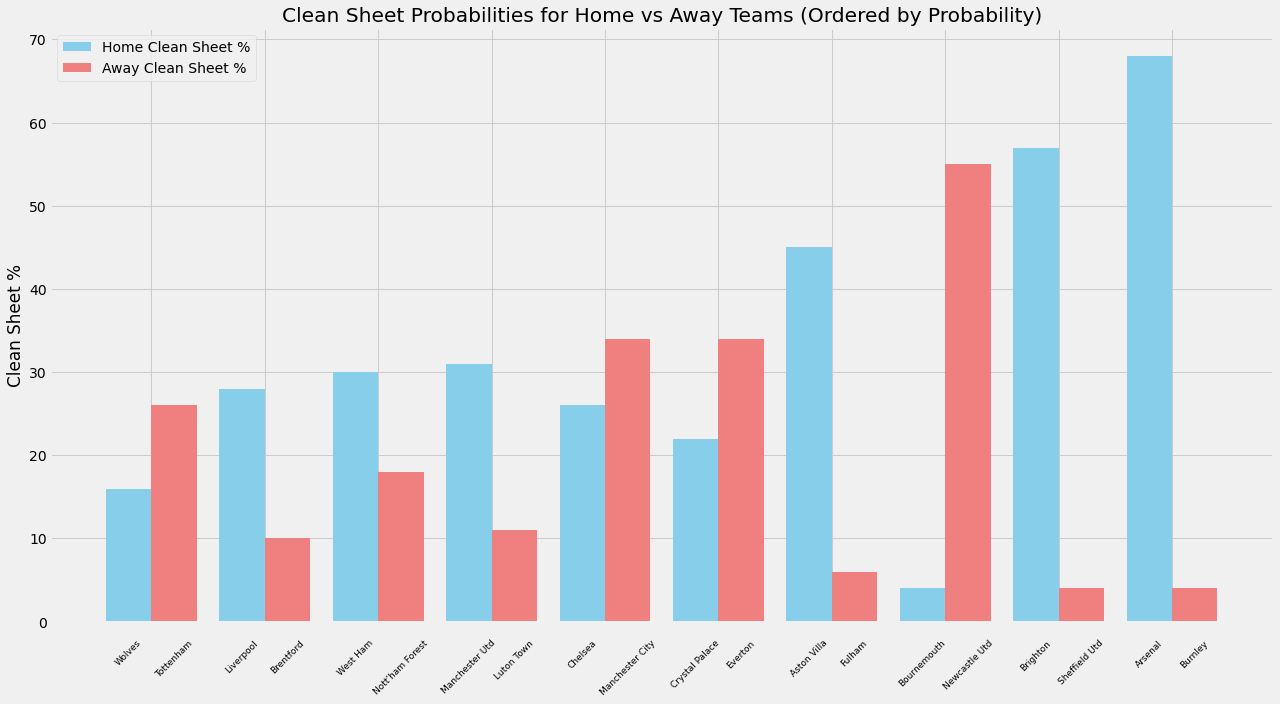

In [59]:

plt.style.use("fivethirtyeight")

week_12 = df_predicted_goals_all_fixtures[df_predicted_goals_all_fixtures['Week'] == 12]

# Load the data from the CSV file
data = week_12

# Calculate the maximum clean sheet probability for each match
data['Max Clean Sheet Probability'] = data[['Home Clean Sheet %', 'Away Clean Sheet %']].max(axis=1)

# Sort the data by the maximum probability in ascending order
sorted_data = data.sort_values(by='Max Clean Sheet Probability', ascending=True).reset_index(drop=True)

# Define the positions for the bars
ind_sorted = np.arange(len(sorted_data))
bar_width = 0.4

# Prepare the figure
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the 'Home Clean Sheet %' bars
sorted_home_bars = ax.bar(ind_sorted, sorted_data['Home Clean Sheet %'], bar_width, label='Home Clean Sheet %', color='skyblue')

# Plot the 'Away Clean Sheet %' bars, shifted by the width of a bar
sorted_away_bars = ax.bar(ind_sorted + bar_width, sorted_data['Away Clean Sheet %'], bar_width, label='Away Clean Sheet %', color='lightcoral')

# Set the x-ticks to be in the middle of the group of two bars and remove the labels
ax.set_xticks(ind_sorted + bar_width / 2)
ax.set_xticklabels([''] * len(sorted_data))

# Adding the team names below the respective bars, slightly closer to the x-axis and rotated
for label, (home_team, away_team) in zip(ind_sorted, zip(sorted_data['Home'], sorted_data['Away'])):
    ax.text(label, -2, home_team, ha='center', va='top', rotation=45, fontsize=9)
    ax.text(label + bar_width, -2, away_team, ha='center', va='top', rotation=45, fontsize=9)

# Set the chart title and labels
ax.set_title('Clean Sheet Probabilities for Home vs Away Teams (Ordered by Probability)')
# ax.set_xlabel('Teams')
ax.set_ylabel('Clean Sheet %')

# Add the legend
ax.legend()

# Adjust the layout to prevent clipping of tick-labels
plt.tight_layout()

# Save the figure to a file
# ordered_clean_sheet_chart_file_path = '/mnt/data/ordered_clean_sheet_probabilities_chart.png'
# plt.savefig(ordered_clean_sheet_chart_file_path)

# Display the plot
plt.show()


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


/var/folders/vd/ly4k__lj017dwcj6ngy4n4c00000gn/T/ipykernel_58110/2387866462.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


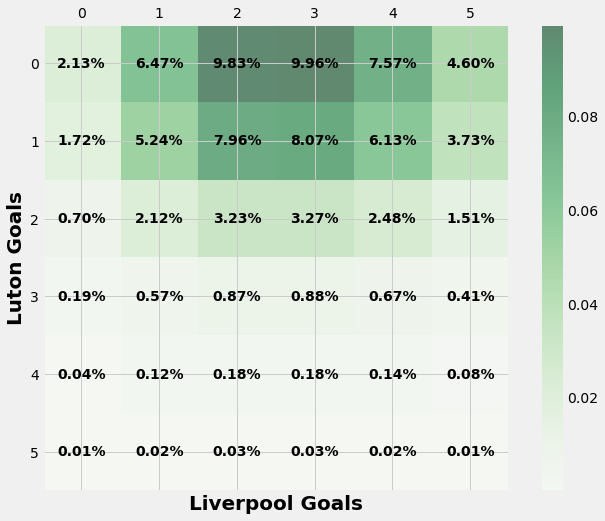

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

team_1 = 'Luton'
team_2 = 'Liverpool'

# Expected goals for each team
xG_H = 0.81
xG_A = 3.04

# Maximum number of goals to simulate
max_goals = 5

# Simulate match outcomes using Poisson distribution
matrix = np.zeros((max_goals+1, max_goals+1))

print(matrix)

for i in range(max_goals+1):
    for j in range(max_goals+1):
        # Probability of Arsenal scoring i goals and Newcastle scoring j goals
        matrix[i, j] = poisson.pmf(i, xG_H) * poisson.pmf(j, xG_A)

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap
cax = ax.matshow(matrix, cmap='Greens', alpha=0.6)

# Add colorbar
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel(f'{team_2} Goals',fontsize=20, fontweight='bold') #, color='grey')
ax.set_ylabel(f'{team_1} Goals',fontsize=20, fontweight='bold')

# Set axis ticks
ax.set_xticks(np.arange(0, max_goals+1, 1))
ax.set_yticks(np.arange(0, max_goals+1, 1))

# Annotate each cell with the numeric value
for i in range(max_goals+1):
    for j in range(max_goals+1):
        ax.text(j, i, '{:.2%}'.format(matrix[i, j]), va='center', ha='center', fontsize=14, fontweight='bold')

# Display the matrix
plt.show()


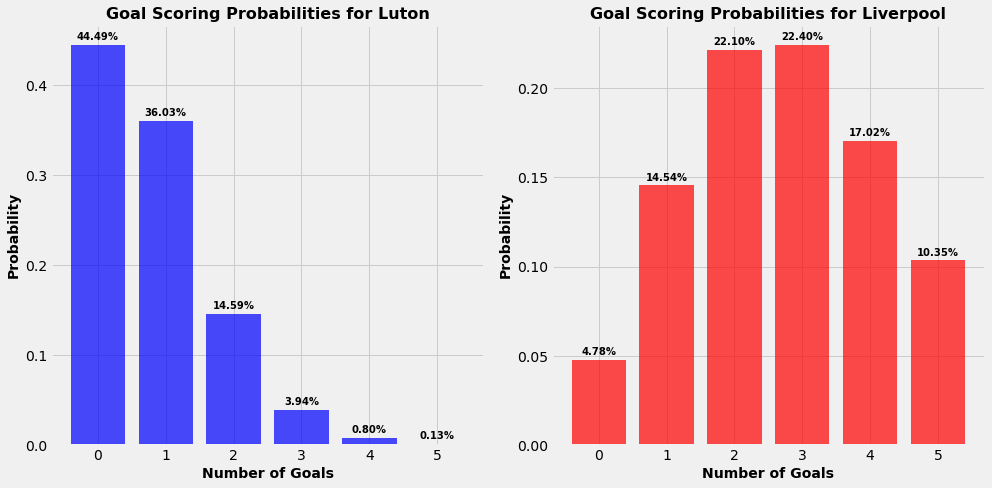

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

team_1 = 'Luton'
team_2 = 'Liverpool'

# Expected goals for each team
xG_H = 0.81
xG_A = 3.04

# Maximum number of goals to simulate
max_goals = 5

# Calculate the probabilities for each team scoring a range of goals up to max_goals
probabilities_team_1 = [poisson.pmf(i, xG_H) for i in range(max_goals+1)]
probabilities_team_2 = [poisson.pmf(i, xG_A) for i in range(max_goals+1)]

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns for each team's bar chart

# Bar chart for Team 1
axs[0].bar(range(max_goals+1), probabilities_team_1, color='blue', alpha=0.7)
axs[0].set_title(f'Goal Scoring Probabilities for {team_1}', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Number of Goals', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Probability', fontsize=14, fontweight='bold')
axs[0].set_xticks(range(max_goals+1))

# Bar chart for Team 2
axs[1].bar(range(max_goals+1), probabilities_team_2, color='red', alpha=0.7)
axs[1].set_title(f'Goal Scoring Probabilities for {team_2}', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Number of Goals', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Probability', fontsize=14, fontweight='bold')
axs[1].set_xticks(range(max_goals+1))

# Annotate each bar with the probability value
for ax in axs:
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2%'),
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='center',
                    size=10, xytext=(0, 8),
                    textcoords='offset points', fontweight='bold')

# Adjust layout for better fit
plt.tight_layout()

# Show the bar charts
plt.show()
